# Homework 2: Supervised Learning


# Dataset: [Pima Indians Diabetes Dataset](https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes)

## Instructions: answer the following questions with data and visuals

- Describe the content of the dataset and its goals
- Describe the features and formulate a hypothesis on which might be relevant in predicting diabetes
- Describe the missing/NULL values. Decide if you should impute or drop them and justify your choice.
- Come up with a benchmark for the minimum performance that an algorithm should have on this dataset
- What's the best performance you can get with kNN? Is kNN a good choice for this dataset?
- What's the best performance you can get with Naive Bayes? Is NB a good choice for this dataset?
- What's the best performance you can get with Logistic Regression? Is LR a good choice for this dataset?
- What's the best performance you can get with Random Forest? Is RF a good choice for this dataset?
- If you could only choose one, which classifer from the above that you already ran is best? How do you define best? (hint: could be prediction accuracy, running time, interpretability, etc)


## Note: you should know by now, but here is the order of importance:

- Your analysis (there is no "right" answer, only good and bad defense of it)
- Your visuals
- Your coding implementation


In [298]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [299]:
# Step 1: load data

NA_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data',
                    sep = ",", header = None)

colnames =  ['preg', 'plas', 'pres', 'skin', 'insu', 'mass', 'pedi', 'age', 'class']

NA_data
NA_data.columns = colnames
NA_data.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Describe the contents of the dataset and it's goals
- The dataset describes females at least 21 years of age pf Pima Indian heritage
- The first 8 columns contain descriptive information about the population
- The 9th column 'class' contains a binary-valued prediction variable as to whether the subject in question may or may not have diabetes (this original prediction using a 75/25 training/testing split had 76% accuracy)

# Describe the features and formulate a hypothesis on which might be relevant in predicting diabetes
- From my remedial education regarding factors that correlate with diabetes, I assume the factors plasma glucose concentration (plas), diastolic BP (pres), BMI (mass), diabetes pedigree function (pedi) and age may all have some explanatory power on the subject having diabetes
- It may very well be the case that all of these variables are relevant metrics by which to predict the instance of diabetes; in this case, the question will be to effectively weight the various characteristics in the most effective manner

# Describe the missing/NULL values. Decide if you should impute or drop them and justify your choice.

In [300]:
# Check for missing data - appears to be no missing data
NA_data.isnull().any()

preg     False
plas     False
pres     False
skin     False
insu     False
mass     False
pedi     False
age      False
class    False
dtype: bool

In [301]:
# Check for outliers
NA_data.describe()

,preg,plas,pres,skin,insu,mass,pedi,age,class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


- It appears missing data has been filled with zeroes, as can be inferred becaues plasma glucose concentratrion (plas), diastolic BP (pres), skin fold thickness (skin), and BMI (mass) cannot realistically achieve zero values
- As several of these zero entries will bias means downward and otherwise skew data if we choose to normalize the variables, I think the most appropriate solution will be either to (1) replace these values with the median of the dataset or (2) drop rows with zero entries

In [302]:
# Drop rows where 'plas', 'pres', 'skin', 'insu' or 'mass' take zero values
clean_data = NA_data.copy()
print "Shape of data before dropping missing rows:"
print clean_data.shape

# Define columns over which to test the zero condition
zerovars = clean_data[['plas', 'pres', 'skin', 'insu', 'mass']]

# Create list denoting zero values in tested variables; subset over this
zeros = np.any(zerovars == 0, axis=1)
clean_data = clean_data.drop(clean_data.index[zeros])

print "\nShape of data after dropping missing rows:"
print clean_data.shape

Shape of data before dropping missing rows:
(768, 9)

Shape of data after dropping missing rows:
(392, 9)


Due to the large quantity of missing data, it seems the prudent solution is to impute missing datapoints with the median values.

In [303]:
# Replace 0 values in the aforementioned columns with median
medians = NA_data.apply(lambda col: col.median(), axis=0)
data = NA_data.copy()

missing_col = ['plas', 'pres', 'skin', 'insu', 'mass']
for col in missing_col:
    filler = NA_data[col].replace(0,medians[col])
    data[col] = filler

In [304]:
data.describe()

,preg,plas,pres,skin,insu,mass,pedi,age,class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,27.334635,94.652344,32.450911,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,9.229014,105.547598,6.875366,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,23.000000,30.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,31.250000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Observe how medians are unchanged, but the minima of the imputed variables are now reflective of biologically plausible outcomes.

In [305]:
# Look at percentage of population that has diabetes
print "Percentage of Native American sample with daibetes = %.2f%%." % (
    100*float(data['class'].sum())/len(data))

Percentage of Native American sample with daibetes = 34.90%.


# Come up with a benchmark for the minimum performance that an algorithm should have on this dataset
- Being a generally ambitious guy, I see the ADAP algorithm employed in the 1988 study by Smith et. al achieved 76% accuracy on the test data after splitting 75/25; I'll thus set a benchmark of 76%, as this accurate an algorithm has already been developed 

# What's the best performance you can get with kNN? Is kNN a good choice for this dataset?

In [306]:
# Assign labels vs data
data_labels = data['class']
data_X = data.drop('class', axis=1).astype(float)

In [307]:
# Split data into testing vs training
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_X, data_labels, 
                                                    test_size=0.25, random_state=7)

In [308]:
# Cross-validate in 10 iterations with 75/25 split for consistency
from sklearn.cross_validation import ShuffleSplit
cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.25, random_state=0)

Since the biological variables are all on various different scales, it seems logical to normalize the variables prior to employing any of the models.

In [309]:
# Normalize the data
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()

X_train_std = stdsc.fit_transform(X_train) 
X_test_std = stdsc.transform(X_test)

In [316]:
X_train_std.describe()

,preg,plas,pres,skin,insu,mass,pedi,age
count,5.760000e+02,5.760000e+02,5.760000e+02,5.760000e+02,5.760000e+02,5.760000e+02,5.760000e+02,5.760000e+02
mean,2.312965e-17,1.040834e-16,1.738699e-16,-5.358368e-17,9.213309e-17,7.735843e-16,1.353084e-16,-1.349229e-18
std,1.000869e+00,1.000869e+00,1.000869e+00,1.000869e+00,1.000869e+00,1.000869e+00,1.000869e+00,1.000869e+00
min,-1.147146e+00,-2.525531e+00,-3.485254e+00,-2.161996e+00,-7.789921e-01,-2.069370e+00,-1.170865e+00,-1.033821e+00
25%,-8.461180e-01,-7.171359e-01,-6.601209e-01,-4.521398e-01,-6.131031e-01,-7.197680e-01,-6.899361e-01,-7.723010e-01
50%,-2.440624e-01,-1.252976e-01,4.616230e-03,-4.521398e-01,-6.131031e-01,-3.060933e-02,-3.044357e-01,-3.364345e-01
75%,6.590208e-01,6.062804e-01,6.693534e-01,5.096545e-01,3.369881e-01,5.724045e-01,4.506604e-01,6.224718e-01
max,3.368271e+00,2.570855e+00,4.159223e+00,7.669678e+00,5.916889e+00,4.951434e+00,5.924160e+00,4.196577e+00


In [310]:
# All independent variables are now normalized
X_train_std = pd.DataFrame(X_train_std, columns=X_train.columns)
X_test_std = pd.DataFrame(X_test_std, columns=X_test.columns)

pd.DataFrame(X_train_std, columns=X_train.columns).head()

,preg,plas,pres,skin,insu,mass,pedi,age
0,3.067243,1.781737,-0.826305,0.295922,-0.613103,0.141680,-0.764916,0.448125
1,-0.244062,1.748857,-1.158674,-0.559006,1.030705,0.041178,0.389314,0.273779
2,1.863132,0.400781,-0.327752,-0.452140,-0.613103,-0.805913,-0.664943,0.273779
3,0.357993,0.170622,0.503169,-0.024676,-0.698561,-0.432619,-0.077225,0.622472
4,0.659021,1.091259,0.170801,0.509654,1.020652,-0.475691,1.134564,0.535299


In [311]:
print (X_train_std.shape)
print (X_test_std.shape)

(576, 8)
(192, 8)


In [312]:
data.corr()

,preg,plas,pres,skin,insu,mass,pedi,age,class
preg,1.000000,0.128213,0.208615,0.032568,-0.055697,0.021546,-0.033523,0.544341,0.221898
plas,0.128213,1.000000,0.218937,0.172143,0.357573,0.231400,0.137327,0.266909,0.492782
pres,0.208615,0.218937,1.000000,0.147809,-0.028721,0.281132,-0.002378,0.324915,0.165723
skin,0.032568,0.172143,0.147809,1.000000,0.238188,0.546951,0.142977,0.054514,0.189065
insu,-0.055697,0.357573,-0.028721,0.238188,1.000000,0.189022,0.178029,-0.015413,0.148457
mass,0.021546,0.231400,0.281132,0.546951,0.189022,1.000000,0.153506,0.025744,0.312249
pedi,-0.033523,0.137327,-0.002378,0.142977,0.178029,0.153506,1.000000,0.033561,0.173844
age,0.544341,0.266909,0.324915,0.054514,-0.015413,0.025744,0.033561,1.000000,0.238356
class,0.221898,0.492782,0.165723,0.189065,0.148457,0.312249,0.173844,0.238356,1.000000


Correlations are generally pretty low between variables, which should bode well for all of our models, but particularly for KNN and NB.

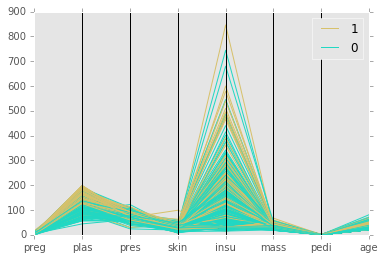

In [315]:
# Assess dispersion among our normalized variables w.r.t. class
plt.figure()
pd.tools.plotting.parallel_coordinates(data, 'class');

The plot above shows that the two variables with the greatest dispersion are plasma glucose concentration (plas) and 2-hr serum insulin (insu), followed distantly by diastolic blood pressure (pres) and age.

In [313]:
# Initialize kNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

In [332]:
# Use GridSearch to find the optimal parameters for kNN
from sklearn.grid_search import GridSearchCV

parameters1 = {'n_neighbors': range(1,15), 'weights': ['uniform', 'distance'],
             'p': range(1,3)}
parameters2 = {'n_neighbors': range(1,20), 'weights': ['uniform', 'distance'],
             'p': range(1,3)}

# Apply GridSearch to the kNN algo using cross-validated data
clf1 = GridSearchCV(knn, parameters1, cv=cv)
clf2 = GridSearchCV(knn, parameters2, cv=cv)

clf1.fit(X_train_std, y_train)
clf2.fit(X_train_std, y_train)

# Assign kNN parameters as the optimal parameters from GridSearch
best_knn1 = clf1.best_estimator_
best_knn2 = clf2.best_estimator_

print clf1.best_params_
print clf2.best_params_

{'n_neighbors': 11, 'weights': 'uniform', 'p': 1}
{'n_neighbors': 18, 'weights': 'distance', 'p': 2}


In [342]:
# Compare accuracy of the models
print "Score of kNN model with 11 neighbors = %.2f%%" % (
    best_knn1.score(X_test_std, y_test)*100)
print "\nScore of kNN model with 18 neighbors = %.2f%%" % (
    best_knn2.score(X_test_std, y_test)*100)

Score of kNN model with 11 neighbors = 78.12%

Score of kNN model with 18 neighbors = 80.73%


In [318]:
# Check percentage of population with diabetes
print "Percentage of population with diabetes = %.2f%%" % (
    float(sum(data['class']==1))/len(data)*100)

Percentage of population with diabetes = 34.90%


In [340]:
# Compare run time of the two models
%timeit best_knn1.predict(X_test_std)

100 loops, best of 3: 3.92 ms per loop


In [341]:
%timeit best_knn2.predict(X_test_std)

100 loops, best of 3: 4.91 ms per loop


In [376]:
print 'Using k=18 takes about %.2f%% more time to run.' % (100*(4.91/3.92-1))

Using k=18 takes about 25.26% more time to run.


**Results**

- The nearest neighbors algorithm delivers almost 81% accuracy on the test data using the parameters resulting from GridSearchCV - e.g. 18 neighbors and exponential weighting with a factor or 2. 


- Using GridSearchCV on the range (1,15), the 'optimal' parameters determined are 11 neighbors using uniform weighting, delivering test-data accuracy of 78% accuracy.  

Unsure if this marginal increase in performance is worth the significantly increased runtime.

In [319]:
# Declare and employ the learning curve graph to assess 
# the bias vs variance of kNN with these parameters
from sklearn.learning_curve import learning_curve
title = 'title'

In [326]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                       train_sizes=np.linspace(.2,1.0,10), n_jobs=1):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    
    plt.xlabel("Number of training examples used")
    plt.ylabel("Accuracy")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

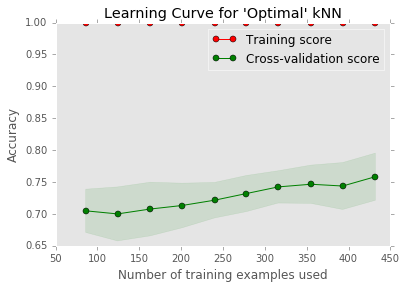

In [346]:
# Produce learning curve chart
plt.figure()
plot_learning_curve(best_knn2, "Learning Curve for 'Optimal' kNN", 
                    X_train_std, y_train, cv=cv);

The model under 'optimal' GridSearch-defined parameters appears to exhibit a significant degrees of bias and variance

In [353]:
# use matplotlib to make a visualization showing how the score
# changes when we change n_neighbors

scores1, scores2 = [], []
n_neighbors = range(1, 101)

# my code
for num in n_neighbors:
    knn1 = KNeighborsClassifier(n_neighbors=num, weights='uniform', p=1)
    knn2 = KNeighborsClassifier(n_neighbors=num, weights='distance', p=2)
    
    knn1.fit(X_train_std, y_train)
    knn2.fit(X_train_std, y_train)
    
    scores1.append(knn1.score(X_test_std,y_test))   
    scores2.append(knn2.score(X_test_std,y_test))   

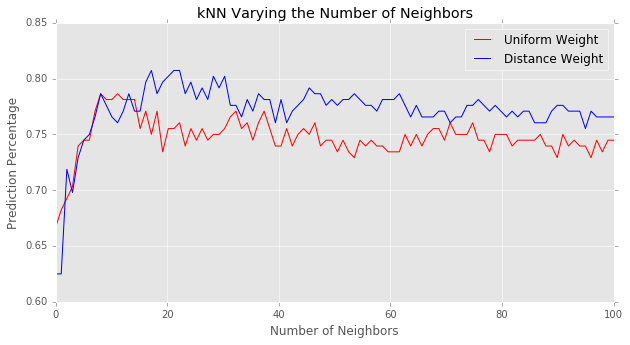

In [369]:
# Plot using MatplotLib
plt.rc('figure', figsize=(10,5))

# Define X-axis
x = np.linspace(0,100,100)

# Define plot
plt.plot(x, scores1, 'r-', label = 'Uniform Weight')
plt.plot(x, scores2, 'b-', label = 'Distance Weight')
plt.legend(loc = 'best')
plt.title('kNN Varying the Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Prediction Percentage')

** Conclusion for KNN**

Nearest neighbors is likely the best model for the data in terms of its combination of test accuracy and explainability, beating the algorithm performance of the original study conducted by UC Irvine (I said I'm competitive). However, I believe this result can likely be improved with some moderate feature engineering. 

# What's the best performance you can get with Naive Bayes? Is NB a good choice for this dataset?

I don't believe Naive Bayes is a good model for the data, as the assumption of independence between the predicting variables seems, despite generally low correlations, to be unfounded. It seems logical that several variables relating to general health and characteristics therein would not be entirely independent, but would rather share some directional relationships.

In [370]:
# Initialize Gaussian Naive Bayes since data has already been normlized
# and multinomial doesn't really make sense in this context
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

In [371]:
# Fit the Gaussian NB model on the training data
nb_model = gnb.fit(X_train_std, y_train)

In [374]:
# Look at accuracy
y_pred = nb_model.predict(X_train_std)

print("Number of mislabeled points in training data out of a total %d points : %d"
      % (X_train_std.shape[0],(y_train != y_pred).sum()))

print "\nThis yields a percent accuracy on training data of %.2f%%." % (
    100-100*float(((y_train != y_pred).sum()))/X_train_std.shape[0])

print "Running the model on the test data yields similar accuracy of %.2f%%." % (
    100*nb_model.score(X_test_std, y_test))

Number of mislabeled points in training data out of a total 576 points : 148

This yields a percent accuracy on training data of 74.31%.
Running the model on the test data yields similar accuracy of 75.00%.


Assess the speed of the Gaussian Naive Bayes

In [375]:
%timeit nb_model.predict(X_test_std)

10000 loops, best of 3: 176 µs per loop


In [443]:
print 'The NB model takes %.2f%% as long as Nearest Neighbors' % (100*(176e-3/3.92))
print 'and is thus %.1fx faster.' % (1/(176e-3/3.92))

The NB model takes 4.49% as long as Nearest Neighbors
and is thus 22.3x faster.


**Results**

- While 75% is reasonable performance, this is not as strong as the performance achieved using nearest neighbors
- Comparing run-time, however, the 176 microseconds taken by the Naive Bayes requires less than 5% the time as a nearest neighbors model
- The 75% performance may have the potential for improvement by adding additional features (reducing variance), which I will come back to time-permitting.

# What's the best performance you can get with Logistic Regression? Is LR a good choice for this dataset?

First try vanilla logistic regression with no penalizing term

In [390]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

lr.fit(X_train_std, y_train)
pd.DataFrame(zip(colnames, lr.coef_[0]))

,0,1
0,preg,0.432425
1,plas,1.101051
2,pres,-0.071503
3,skin,0.119928
4,insu,-0.155528
5,mass,0.564155
6,pedi,0.386138
7,age,0.089754


In [399]:
# Make predictions using X_test_std 
y_pred = lr.predict(X_test_std)

In [400]:
# Time prediction using the logistic regression
%timeit lr.predict(X_test_std)

The slowest run took 4.96 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 79.2 µs per loop


In [392]:
# calculate classification accuracy
from sklearn import metrics
print "The OOB logistic regression achieves accuracy of %.2f%%." % (
    metrics.accuracy_score(y_test, y_pred)*100)

The OOB logistic regression achieves accuracy of 77.08%.


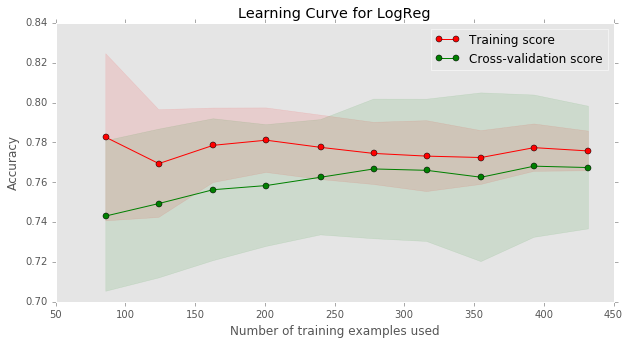

In [393]:
plot_learning_curve(lr, 'Learning Curve for LogReg', X_train_std, y_train, cv=cv);

- The out of the box logistic regression exhibits significant bias with only a moderate degree of variane. Assessing the initial regression coefficients, it seems that we may see some improvement by employing lasso and/or ridge.
- Despite its high-bias property, the model delivers 77% accuracy with no additional model tuning, along with a run-time of less than half that of Naive Bayes

In [401]:
# Tune regression parameters
parameters = {'C': np.linspace(1e-5, 1e5, 100), 'class_weight': [None, 'balanced']}
clf = GridSearchCV(lr, parameters, cv=cv)
clf.fit(X_train_std, y_train)

GridSearchCV(cv=ShuffleSplit(576, n_iter=10, test_size=0.25, random_state=0),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-05,   1.01010e+03, ...,   9.89899e+04,   1.00000e+05]), 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [402]:
# View resulting parameters from the GridSearch
clf.best_params_

{'C': 1010.1010199999999, 'class_weight': None}

In [403]:
# View score of regression on train data
clf.best_score_

0.76736111111111116

In [404]:
best_log = clf.best_estimator_

In [406]:
y_pred_tune = clf.predict(X_test_std)
print "The tuned logistic regression achieves accuracy of %.2f%%." % (
    metrics.accuracy_score(y_test, y_pred_tune)*100)

The tuned logistic regression achieves accuracy of 77.08%.


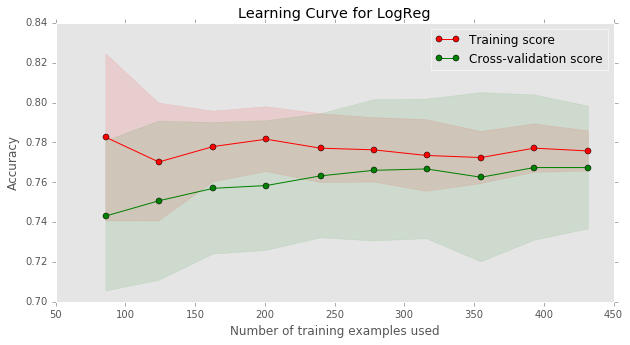

In [405]:
plot_learning_curve(best_log, 'Learning Curve for LogReg', X_train_std, y_train, cv=cv);

Notes for tuning logistic regression:

- penalty: 'l1' for lasso, 'l2' for ridge
- C: smaller values imply higher regularization and therefore more robustness against overfitting but potentially weaker predictions

In [255]:
# Try logist regression again using lasso and ridge respectively
lasso_reg = LogisticRegression(penalty='l1')
ridge_reg = LogisticRegression(penalty='l2')

In [259]:
# Fit two models to the training data
# lasso_reg.fit(X_train_std,y_train)
# ridge_reg.fit(X_train_std,y_train)

# Compare Coefficients
#print pd.DataFrame(zip(colnames, lasso_reg.coef_[0]))
#print pd.DataFrame(zip(colnames, ridge_reg.coef_[0]))

In [256]:
# Declare parameters over which to optimize the regression
parameters = {'C': np.linspace(1e-5, 1e5, 100), 'class_weight': [None, 'balanced']}

In [257]:
# Fit model using lasso regression
lasso_model = GridSearchCV(lasso_reg, parameters, cv=cv)
lasso_model.fit(X_train_std, y_train)
lasso_model.best_params_

{'C': 1010.1010199999999, 'class_weight': None}

In [263]:
# Test accuracy of lasso model on training set
lasso_model.best_score_

0.76736111111111116

In [260]:
best_lasso = lasso_model.best_estimator_

In [407]:
y_pred_lasso = lasso_model.predict(X_test_std)
print "The tuned logistic regression achieves accuracy of %.2f%%." % (
    metrics.accuracy_score(y_test, y_pred_lasso)*100)

The tuned logistic regression achieves accuracy of 77.08%.


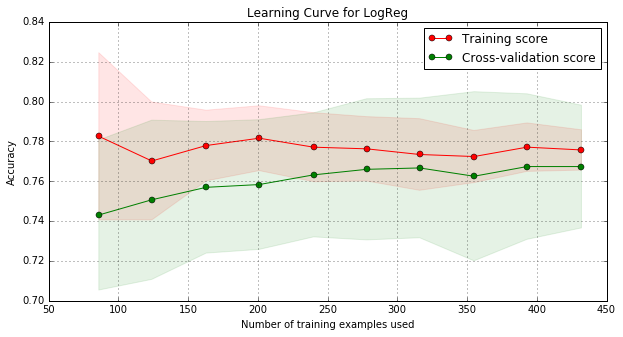

In [268]:
plot_learning_curve(best_lasso, 'Learning Curve for LogReg', X_train_std, y_train, cv=cv);

In [258]:
# Fit model using ridge regression
ridge_model = GridSearchCV(ridge_reg, parameters, cv=cv)
ridge_model.fit(X_train_std, y_train)
ridge_model.best_params_

{'C': 1010.1010199999999, 'class_weight': None}

In [264]:
# Test accuracy of ridge model on training set
ridge_model.best_score_

0.76736111111111116

In [261]:
best_ridge = ridge_model.best_estimator_

In [408]:
y_pred_ridge = ridge_model.predict(X_test_std)
print "The tuned logistic regression achieves accuracy of %.2f%%." % (
    metrics.accuracy_score(y_test, y_pred_ridge)*100)

The tuned logistic regression achieves accuracy of 77.08%.


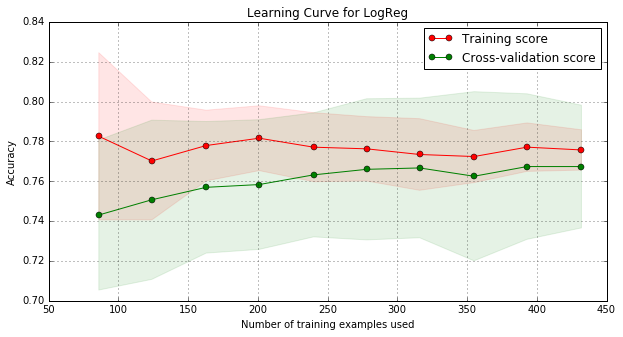

In [270]:
plot_learning_curve(best_ridge, 'Learning Curve for LogReg', X_train_std, y_train, cv=cv);

In [265]:
# Compare Coefficients
print pd.DataFrame(zip(colnames, best_lasso.coef_[0]))
print pd.DataFrame(zip(colnames, best_ridge.coef_[0]))

      0         1
0  preg  0.443380
1  plas  1.125244
2  pres -0.079059
3  skin  0.118958
4  insu -0.164576
5  mass  0.577477
6  pedi  0.393933
7   age  0.085648
      0         1
0  preg  0.443588
1  plas  1.125360
2  pres -0.079090
3  skin  0.118980
4  insu -0.164617
5  mass  0.577462
6  pedi  0.393964
7   age  0.085507


In [419]:
%timeit best_lasso.score(X_test_std, y_test) 

1000 loops, best of 3: 252 µs per loop


In [420]:
# Prediction accuracy of lasso model
best_lasso.score(X_test_std, y_test)

0.77083333333333337

In [410]:
# Prediction accuracy of ridge model
best_ridge.score(X_test_std, y_test)

0.77083333333333337

In [428]:
print "The lasso model takes about about %.2f%% longer than the untuned model" % (
    100*(252./79.2-1))
print "about takes about %.2f%% slower than Naive Bayes." % (100*(252./176-1))

The lasso model takes about about 218.18% longer than the untuned model
about takes about 43.18% slower than Naive Bayes.


**Results**

- Accuracy of the logistic regression is on par with the other models
- However, as discussed in the class, this model can sometimes be difficult to explain to a non-technical audience
- In terms of speed, the untuned logistic regression is the fastest of the 4 models
- After employing a penalty term, the model takes about 3x as long, making it a still fast though less desirable model

# What's the best performance you can get with Random Forest? Is RF a good choice for this dataset?

In [272]:
# Initialize random forest
from sklearn.ensemble import RandomForestClassifier

# Fit model to the training data
rf = RandomForestClassifier(n_estimators = 20)
rf.fit(X_train_std, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [282]:
# Assess predictive performance of random forest
print "The initial random forest achieved performance of %.2f%%." %(
    100*rf.score(X_test_std, y_test))

The initial random forest achieved performance of 75.00%.


In [434]:
%timeit rf.predict(X_test_std)

1000 loops, best of 3: 1.62 ms per loop


In [275]:
# Assess feature importance across random forest
features = X_train_std.columns
feature_importances = rf.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df.head()

,Features,Importance Score
1,plas,0.256370
5,mass,0.175256
7,age,0.148867
6,pedi,0.119683
2,pres,0.089247


This model appears to derive the most predictive power from the plasma glucose concentration, BMI, age, the diabetes pedigree function, and blood pressure. 

Assess the cross-validated scores across a range of tree numbers.

In [430]:
from sklearn.cross_validation import cross_val_score

# Assess cross-validated accuracy of the initial random forest with 20 trees
scores = cross_val_score(rf, X_train_std, y_train, scoring='accuracy', cv=5)
print "Accuracy of the initial model:"
print('CV accuracy {}, Average accuracy {}\n'.format(scores, scores.mean()))

# Assess cross-validated results across a range of forest sizes
for n_trees in range(1, 100, 10):
    model = RandomForestClassifier(n_estimators = n_trees)
    scores = cross_val_score(model, X_train_std, y_train, scoring='accuracy' ,cv=5)
    model.fit(X_train_std, y_train)
    print('CV accuracy {}, Average accuracy {}'.format(scores, scores.mean()))
    print "Accuracy of %d tree model on the test data is %.2f%%.\n" % (
        n_trees, 100*model.score(X_test_std, y_test))

Accuracy of the initial model:
CV accuracy [ 0.75862069  0.76724138  0.6637931   0.78070175  0.75438596], Average accuracy 0.744948578342

CV accuracy [ 0.70689655  0.63793103  0.64655172  0.78947368  0.74561404], Average accuracy 0.705293405929
Accuracy of 1 tree model on the test data is 67.71%.

CV accuracy [ 0.70689655  0.78448276  0.73275862  0.77192982  0.77192982], Average accuracy 0.753599516031
Accuracy of 11 tree model on the test data is 78.12%.

CV accuracy [ 0.76724138  0.75862069  0.70689655  0.79824561  0.76315789], Average accuracy 0.758832425892
Accuracy of 21 tree model on the test data is 77.08%.

CV accuracy [ 0.75862069  0.79310345  0.67241379  0.79824561  0.78070175], Average accuracy 0.760617059891
Accuracy of 31 tree model on the test data is 77.08%.

CV accuracy [ 0.75        0.77586207  0.6637931   0.81578947  0.75438596], Average accuracy 0.751966122202
Accuracy of 41 tree model on the test data is 78.65%.

CV accuracy [ 0.75        0.76724138  0.68103448  0.

In [290]:
scores = pd.DataFrame(range(1,101))
for est in range(1,101):
    rf_model = RandomForestClassifier(n_estimators = est)
    rf_model.fit(X_train_std, y_train)
    scores.ix[est, 'score'] = rf_model.score(X_test_std, y_test)

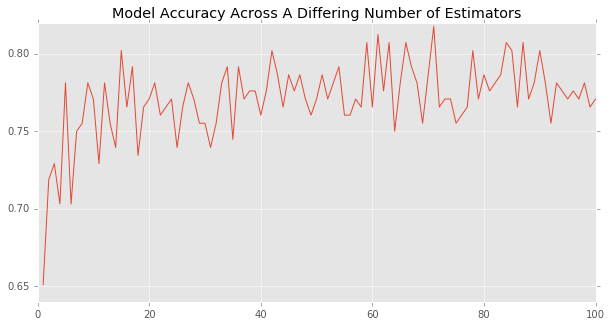

In [292]:
plt.style.use('ggplot')
scores.score.plot()
plt.title("Model Accuracy Across A Differing Number of Estimators")

**Run same analysis on non-normalized data.**

In [288]:
# Fit model to the training data
rf = RandomForestClassifier(n_estimators = 20)
rf.fit(X_train, y_train)

# Assess predictive performance of random forest
print "The initial random forest achieved performance of %.2f%%." %(
    100*rf.score(X_test, y_test))

The initial random forest achieved performance of 74.48%.


In [433]:
%timeit rf.predict(X_test)

100 loops, best of 3: 1.78 ms per loop


In [431]:
# Assess cross-validated accuracy of the initial random forest with 20 trees
scores = cross_val_score(rf, X_train, y_train, scoring='accuracy' , cv=5)
print "Accuracy of the initial model:"
print('CV accuracy {}, Average accuracy {}\n'.format(scores, scores.mean()))

# Assess cross-validated results across a range of forest sizes
for n_trees in range(1, 100, 10):
    model = RandomForestClassifier(n_estimators = n_trees)
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy',cv=5)
    model.fit(X_train, y_train)
    print('CV accuracy {}, Average accuracy {}'.format(scores, scores.mean()))
    print "Accuracy of %d tree model on the test data is %.2f%%.\n" % (
        n_trees, 100*model.score(X_test, y_test))

Accuracy of the initial model:
CV accuracy [ 0.72413793  0.75        0.72413793  0.77192982  0.74561404], Average accuracy 0.743163944344

CV accuracy [ 0.67241379  0.73275862  0.60344828  0.6754386   0.68421053], Average accuracy 0.673653962492
Accuracy of 1 tree model on the test data is 65.10%.

CV accuracy [ 0.71551724  0.79310345  0.71551724  0.8245614   0.71929825], Average accuracy 0.753599516031
Accuracy of 11 tree model on the test data is 75.52%.

CV accuracy [ 0.72413793  0.75862069  0.65517241  0.77192982  0.74561404], Average accuracy 0.731094978826
Accuracy of 21 tree model on the test data is 77.08%.

CV accuracy [ 0.73275862  0.73275862  0.68965517  0.78947368  0.77192982], Average accuracy 0.743315184513
Accuracy of 31 tree model on the test data is 75.00%.

CV accuracy [ 0.74137931  0.78448276  0.74137931  0.81578947  0.77192982], Average accuracy 0.770992135511
Accuracy of 41 tree model on the test data is 77.08%.

CV accuracy [ 0.69827586  0.77586207  0.70689655  0.

Differences of the random forest for the standardized versus non-standardized data are minimal, which is to be expected due to the nonlinearity of the random forest model.

# If you could only choose one, which classifer is best? How do you define best? 

- Compare prediction accuracy, run time, interpretability, etc.

Choosing a single model on the joint bases of accuracy, run time and interpretability, I would choose the nearest neighbors algorithm, and particularly the instance with fewer neighbors. Though this model takes more than 20x longer than Naive Bayes and seems particularly sluggish when compared to logistic regression, for data of this size, the speed is not too much a hindrance. Furthermore, the model exhibits moderate variance, which should have the potential to diminish with more data.

But the primary reason I would prefer Nearest Neighbors is the interpretability. While Naive Bayes, logistic regression, and random forests have the potential for greater speed and accuracy, the gains in speed, at least in this instance, seem to be outweighed by the remarkable ease with which Nearest Neighbors can be explained to non-technical audiences (I've tested this).